In [262]:
from sklearn import model_selection, linear_model, metrics
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [263]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Загрузка исходных данных

Тренировочные данные

In [264]:
train_data = pd.read_csv('train_titanic.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Тестовые данные

In [265]:
test_data = pd.read_csv('test_titanic.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Описание признаков

1.  PassangerId - идентификационный номер пассажира или члена экипажа
2.  Pclass      - класс каюты (значения: 1, 2, 3)
3.  Name        - имя пассажира или члена экипажа
4.  Sex         - пол (значения: male, female)
5.  Age         - возраст пассажира или члена экипажа
6.  SibSp       - родственные отношения (брат, сестра, сводный брат, сводная сестра)
7.  Parch       - родственные отношения (мать, отец, дочь, сын, приёмная дочь, приёмный сын), 0 - ребёнок с няней
8.  Ticket      - номер билета
9.  Fare        - стоимость билета
10. Cabin       - номер каюты
11. Embarked    - пункт отправления пассажира (значения: C-Cherbourg, Q-Queenstown, S-Southampton)

# Анализ пропущенных данных

Объединим тестовые и тренировочные данные

In [266]:
all_data = pd.concat([train_data, test_data], ignore_index=True)

In [267]:
# Размеры данных
print('Размер тренировочных данных:\t', train_data.shape, '\n')
print('Размер тестовых данных:\t\t', test_data.shape, '\n')
print('Размер объединенных данных:\t', all_data.shape, '\n')

Размер тренировочных данных:	 (891, 12) 

Размер тестовых данных:		 (418, 11) 

Размер объединенных данных:	 (1309, 12) 



In [268]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [269]:
print('Количество пропущенных данных:')
all_data.isnull().sum()

Количество пропущенных данных:


Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

# Исследование зависимости выживаемости от возраста

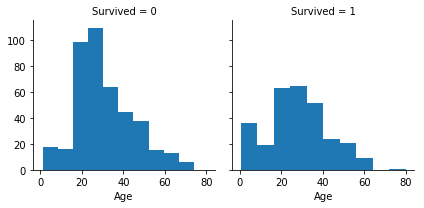

In [270]:
g = sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Age')
#age_surve.head()

# Исследование зависимости класса каюты от возраста

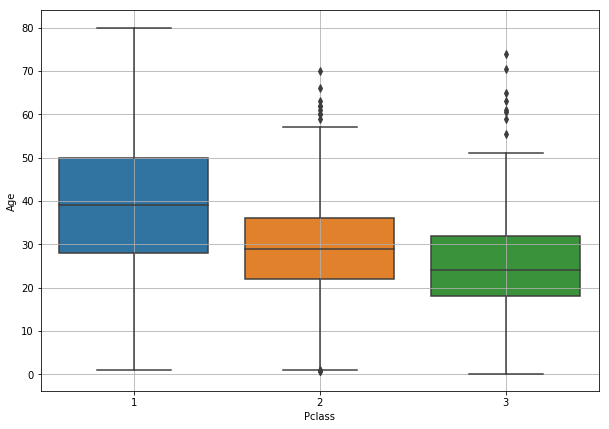

In [271]:
plt.figure(figsize=(10, 7))
sns.boxplot(x=all_data['Pclass'], y=all_data['Age'])
plt.grid()

# Расчитаем средний возраст пассажиров для каждого из классов

In [272]:
def non_null_val(arr):
    res = []
    for val in arr:
        if val!=0:
            res.append(val)
    return res

In [273]:
age_pclass1 = (all_data.Pclass==1)*all_data.Age.fillna(0)
mean_age_pclass1 = np.mean(non_null_val(age_pclass1))
mean_age_pclass1 = mean_age_pclass1.round(1)

print('средний возраст для пассажиров 1-го класса:', mean_age_pclass1)

age_pclass2 = (all_data.Pclass==2)*all_data.Age.fillna(0)
mean_age_pclass2 = np.mean(non_null_val(age_pclass2))
mean_age_pclass2 = mean_age_pclass2.round(1)

print('\nсредний возраст для пассажиров 2-го класса:', mean_age_pclass2)

age_pclass3 = (all_data.Pclass==3)*all_data.Age.fillna(0)
mean_age_pclass3 = np.mean(non_null_val(age_pclass3))
mean_age_pclass3 = mean_age_pclass3.round(1)

print('\nсредний возраст для пассажиров 3-го класса:', mean_age_pclass3)

средний возраст для пассажиров 1-го класса: 39.2

средний возраст для пассажиров 2-го класса: 29.5

средний возраст для пассажиров 3-го класса: 24.8


In [274]:
# сделаем словарь класс - средний возраст
pclass_age = {1: mean_age_pclass1,
              2: mean_age_pclass2,
              3: mean_age_pclass3}

# Заменим пропущенные значения возраста средними по классу

In [275]:
count = 0
for age, pclass in zip(all_data['Age'], all_data['Pclass']):
    if pd.isna(age):
        all_data['Age'][count] = pclass_age[pclass]
    count +=1

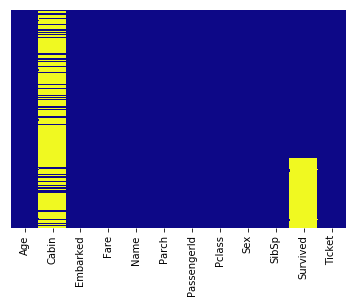

In [276]:
sns.heatmap(all_data.isna(),yticklabels=False,cbar=False, cmap='plasma')